# BindingDB clusters

On this page, I'll apply the cluster labels to the BindingDB data, and
investigate the distribution of clusters.


## Setup

Add user's current working directory to search path:

In [1]:
import sys
sys.path = [r"C:\sw\plb"] + sys.path

Also change current working directory:

In [2]:
import os
os.chdir(r"C:\sw\plb")

Imports:

In [3]:
from collections import Counter
from pathlib import Path

import bokeh.io
import myst_nb

from src.config import get_config
from src.data.bindingdb.io import read_bdb_single_chain
from src.data_structure_utils import read_tsv
from src.stats_utils import (
    get_stats_from_counter,
    print_counter_stats_df,
)
from src.plotting_functions import (
    plot_cluster_counts_bdb_biolip_combined,
    plot_cluster_counts_single_dataset,
)


Set up document options:

In [4]:
# This import automatically sets seeds
import src.set_seed

# Nice pandas tables
import itables
itables.init_notebook_mode(all_interactive=True)
itables.options.maxColumns = 0  # unlimited columns
itables.options.maxBytes = 32000000
itables.options.classes = ["display", "nowrap"]
itables.options.order = [] # disable auto-sorting

# Set up bokeh interactive plots
bokeh.io.output_notebook()

<IPython.core.display.Javascript object>

Loading BokehJS ...

Get filepaths of data directories:

In [5]:
config = get_config()
dir_data = Path(config["data_directory"])
dir_features = Path(config["features_directory"])

Load dataframe with cluster assignments:

In [6]:
df_bdb_with_clusters = read_bdb_single_chain(dir_features / "df_bdb_with_clusters.tsv")

## Distribution of protein clusters

Instead of considering the distribution of individual protein sequences in
BindingDB, let's consider the distribution of protein sequence clusters. This is
basically the same as "merging" any protein sequences that are evolutionarily
related into a single object.

Total number of entries: 99367
Total number of unique entries: 439
Distribution of frequencies of individual entries, linear scale (left):
Distribution of frequencies of individual entries, log scale (right):


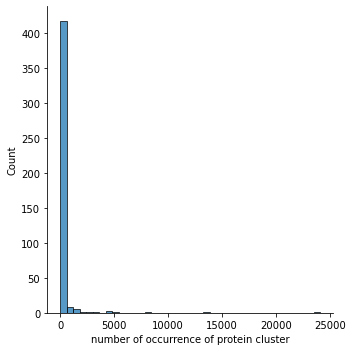

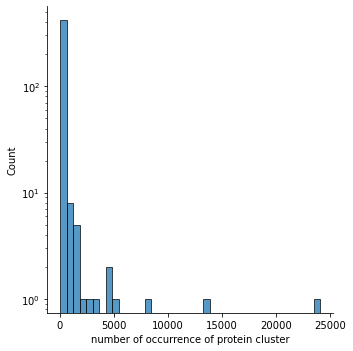

In [7]:
bdb_cluster_counts_p: Counter[str] = Counter(df_bdb_with_clusters["protein_cluster"])
bdb_cluster_stats_p = get_stats_from_counter(
    counts=bdb_cluster_counts_p,
    ntop=30,
    nbins=40,
    name_of_thing_being_counted="protein_cluster_label",
    xaxis_name="number of occurrence of protein cluster",
    do_show=True,
)

Most commonly occuring protein clusters:

In [8]:
print_counter_stats_df(bdb_cluster_stats_p)

Loading... (need help?)


## Distribution of ligand clusters

Similarly, let's now consider the distribution of ligand clusters. We're
basically treating each cluster as a single object, so that very similar
molecules will be treated as the same thing (i.e. there will be "redundant"
data).

Total number of entries: 99367
Total number of unique entries: 4621
Distribution of frequencies of individual entries, linear scale (left):
Distribution of frequencies of individual entries, log scale (right):


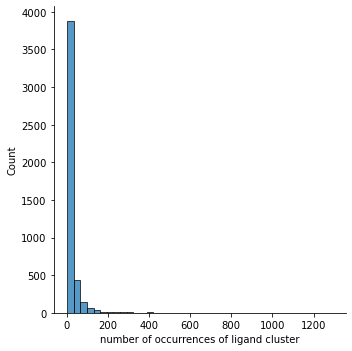

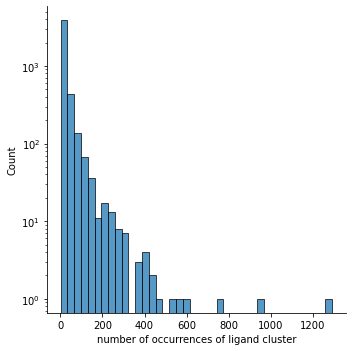

In [9]:
bdb_cluster_counts_l: Counter[str] = Counter(df_bdb_with_clusters["ligand_cluster"])
bdb_cluster_stats_l = get_stats_from_counter(
    counts=bdb_cluster_counts_l,
    ntop=30,
    nbins=40,
    name_of_thing_being_counted="ligand_cluster_label",
    xaxis_name="number of occurrences of ligand cluster",
    do_show=True,
)

Most commonly occuring ligand clusters:

In [10]:
print_counter_stats_df(bdb_cluster_stats_l)

Loading... (need help?)


## Distribution of (p, l) cluster tuples

Finally, the actual BindingDB data is composed of a series of protein-ligand
pairs. For any particular BindingDB entry, denote the protein cluster of its
protein sequence as $p$, and the ligand cluster of its ligand SMILES as $l$.
Then, each BindingDB entry can be described with a 2-tuple $(p,l)$.

Before generating the statistics, here are some general comments about the
distribution of $(p,l)$ tuples:

- Each particular $(p,l)$ tuple could occur 0 times, 1 time, or more than 1
  times:
  - Occuring 0 times means that the particular protein-ligand cluster pairing
    has no recorded binding values in the dataset
  - Occuring 1 time means that there's a single binding value recorded between a
    protein from cluster $p$ and a ligand from cluster $l$
  - Occuring more than 1 time means that there are multiple binding values
    recorded for proteins from cluster $p$ and ligands from cluster $l$. For any
    two (or more) of these binding values, the particular proteins or ligands
    involved may be identical, or they may be different. There's no way to tell
    from the cluster assignments alone.
- Most possible $(p,l)$ tuples aren't present in the dataset. This makes sense,
  because there are too many combinations of proteins and ligands to
  experimentally measure all of them. The net result is that the $(p,l)$ tuples
  that we do have data for are quite sparse, as you'll see below.
- Some particular $p$ clusters are overrepresented. This occurs because
  particular proteins (or their families) have been extensively studied, and
  have a lot of binding values present.
- Similarly, some ligand clusters $l$ are overrepresented. This probably
  corresponds to drug molecules that have gone through a lot of binding assays
  with various proteins.

Anyway, here are some statistics for the number of occurrences of the $(p,l)$
cluster tuples:

Total number of entries: 99367
Total number of unique entries: 8446
Distribution of frequencies of individual entries, linear scale (left):
Distribution of frequencies of individual entries, log scale (right):


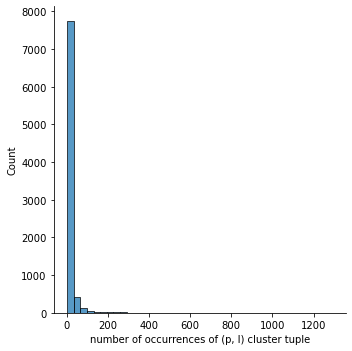

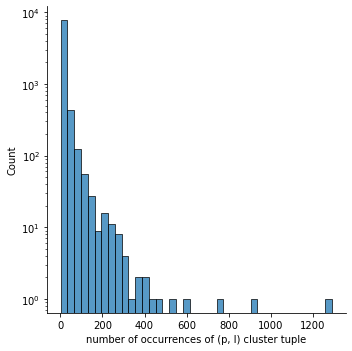

In [11]:
bdb_cluster_counts_pl: Counter[tuple[str, str]] = Counter(
    zip(df_bdb_with_clusters["protein_cluster"], df_bdb_with_clusters["ligand_cluster"])
)
bdb_cluster_stats_pl = get_stats_from_counter(
    counts=bdb_cluster_counts_pl,
    ntop=30,
    nbins=40,
    name_of_thing_being_counted="pl_cluster_tuple",
    xaxis_name="number of occurrences of (p, l) cluster tuple",
    do_show=True,
)

And the most commonly occuring $(p,l)$ cluster pairs:

In [12]:
print_counter_stats_df(bdb_cluster_stats_pl)

Loading... (need help?)


As you can see, the entire filtered BindingDB dataset has been distilled down to
a reasonably small number of $(p,l)$ cluster tuples. Most of these (nearly 8000)
appear only once, or a few times. Then, there's a small number of $(p,l)$
cluster pairs that appear tens or even hundreds of times.

We can also plot a few heatmaps of the $(p,l)$ tuple occurrences. For these
heatmaps, the y-coordinate represents the $p$ cluster label, and the
x-coordinate represents the $l$ cluster label. The corresponding square on the
heatmap is filled in if the $(p,l)$ tuple is present in the dataset. To make it
easier to visualise, I've clipped all counts that are greater than 1 (i.e. the
square is fully shaded if the $(p,l)$ tuple is present at all, regardless of
whether it occurs only 1 time, or 100s of times).

Also, I've reindexed the protein and ligand cluster labels (independently of
each other), so that both cluster labels start counting up from zero. The main
reason I did this is because `mmseqs` outputs its protein cluster labels as
non-consecutive integers, which makes it really inconvenient to plot as a
heatmap. The cluster labels are more or less irrelevant, so it should be fine to
interchange them (as I've done here). This is equivalent to permuting the rows
or columns of the heatmap matrix.

A side-effect of this reindexing is that there are lots of points lying close to
the main diagonal of the heatmap. I think this is because there are lots of
$(p,l)$ tuples where both $p$ and $l$ are new, and after the cluster labels have
been independently reindexed, it means there are lots of cases where both $p$
and $l$ increment at the same time (resulting in many points lying along the
line $p=l$, or close to it).

Anyway, here's the plot. It's interactive, so you should be able to pan around,
and zoom in and out as needed:

In [13]:
plot_cluster_counts_single_dataset(
    pl_counts=bdb_cluster_counts_pl, backend="bokeh", permute_rows_and_columns=False
)

There are horizontal and vertical lines present in the data; these correspond to
the "overrepresented" clusters (e.g. where a particular protein has been studied
in combination with many different ligands, or vice versa).

Anyway, because the cluster labels are interchangeable, I've generated a version
of the plot where the rows and columns are permuted so that most of the data
points (including the overrepresented clusters) are placed in the top left
corner:

In [14]:
plot_cluster_counts_single_dataset(
    pl_counts=bdb_cluster_counts_pl, backend="bokeh", permute_rows_and_columns=True
)